In [115]:
import json, re
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

def plotPretext(path,title,start,end=None):
    txt = open(path).read()
    txtL = re.findall("\{(.*)\}", txt) # epoch split
    plt.title(title, fontsize=16)
    plt.xlabel("epochs", fontsize=16)
    plt.ylabel("loss", fontsize=16)
    train_loss_L = [ round(float(json.loads("{"+txtL[i]+"}")["train_loss"]),5) for i in range(len(txtL)) ]
    plt.plot(train_loss_L[start:end])
    plt.grid('on')
    plt.show()
    n = len(train_loss_L)
    print(f"min(zip(train_loss_L,range(n)))={min(zip(train_loss_L,range(n)))}")
    return train_loss_L

def plotFinetune(path,title,start=0,end=None):
    txt = open(path).read()
    txtL = re.findall("\{(.*)\}", txt) # epoch split
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    #
    ax[0].set_title(title, fontsize=16)
    ax[0].set_xlabel("epochs", fontsize=16)
    ax[0].set_ylabel("loss", fontsize=16)
    train_loss_L = [ round(float(json.loads("{"+txtL[i]+"}")["train_loss"]),5) for i in range(len(txtL)) ]
    ax[0].plot(train_loss_L[start:end])
    val_loss_L   = [ round(float(json.loads("{"+txtL[i]+"}")["val_loss"]),5) for i in range(len(txtL)) ]
    ax[0].plot(val_loss_L[start:end])
    n = len(train_loss_L)
    ax[0].grid('on')
    print(f"min(zip(val_loss_L,range(n)))={min(zip(val_loss_L,range(n)))}")
    #
    ax[1].set_title(title, fontsize=16)
    ax[1].set_xlabel("epochs", fontsize=16)
    ax[1].set_ylabel("acc", fontsize=16)
    train_acc_L = [ round(float(json.loads("{"+txtL[i]+"}")["train_class_acc"]),5) for i in range(len(txtL)) ]
    ax[1].plot(train_acc_L[start:end])
    val_acc_L = [ round(float(json.loads("{"+txtL[i]+"}")["val_acc1"])/100,5) for i in range(len(txtL)) ]
    ax[1].plot(val_acc_L[start:end])
    ax[1].grid('on')
    print(f"max(zip(val_acc_L,range(n)))={max(zip(val_acc_L,range(n)))}")
    plt.show()
    return val_loss_L, val_acc_L

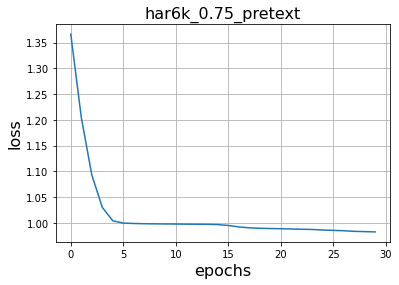

min(zip(train_loss_L,range(n)))=(0.98201, 29)


In [26]:
trainL = plotPretext("../exps/har6k_0.75_incomplete/pre/log.txt","har6k_0.75_pretext",0)

min(zip(val_loss_L,range(n)))=(0.11574, 185)
max(zip(val_acc_L,range(n)))=(1.0, 185)


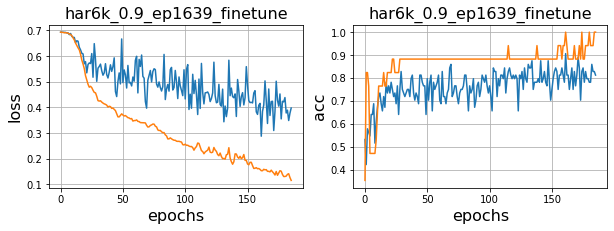

In [140]:
valLossL, valLAccL = plotFinetune("../exps/har6k_0.9/ft/log.txt","har6k_0.9_ep1639_finetune",0)

{1: 10, 0: 7}


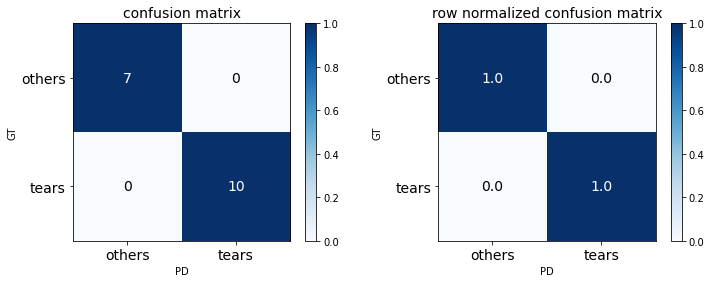

In [148]:
class DownstreamResult:
    def __init__(self, labelPath, resultPath, classes=['others','tears']):
        self.labelPath, self.resultPath, self.classes = labelPath, resultPath, classes
        self.df = pd.read_csv(labelPath, header=None, delimiter=' ')
        self.df[0] = self.df[0].apply(lambda s:'/'.join(s.split('/')[-2:]))
        self.df['pred'] = json.load(open(resultPath,'r'))
        #self.df['pred'] = [0]*16+[1]
    
    def getDF(self):
        return self.df
    
    def getWrong(self):
        return self.df[ self.df[1]!=self.df['pred'] ]
    
    def plotConfusion(self):
        catNumsDict = self.df[1].value_counts().to_dict()
        print(catNumsDict)
        n = len(self.classes)
        M, N = np.zeros((n,n)), np.zeros((n,n))
        for i in range(len(self.df)):
            _, gt, pd = self.df.loc[i]
            M[gt][pd]+=1
            N[gt][pd]+=1/catNumsDict[gt]
        N = np.round(N,3)
        plt.figure(figsize=(12,4))
        #
        plt.subplot(1,2,1)
        plt.title("confusion matrix", fontsize=14)
        plt.xlabel("PD")
        plt.ylabel("GT")
        plt.xticks(range(n),self.classes, fontsize=14)
        plt.yticks(range(n),self.classes, fontsize=14)
        plt.imshow(N, cmap=mpl.cm.Blues)
        plt.colorbar()
        for i in range(n):
            for j in range(n):
                plt.annotate(int(M[i][j]), xy=(j,i), ha="center", va="center", color="black" if N[i][j]<0.5 else "white", fontsize=14)
        #
        plt.subplot(1,2,2)
        plt.title("row normalized confusion matrix", fontsize=14)
        plt.xlabel("PD")
        plt.ylabel("GT")
        plt.xticks(range(n),self.classes, fontsize=14)
        plt.yticks(range(n),self.classes, fontsize=14)
        plt.imshow(N, cmap=mpl.cm.Blues)
        plt.colorbar()
        for i in range(n):
            for j in range(n):
                plt.annotate(N[i][j], xy=(j,i), ha="center", va="center", color="black" if N[i][j]<0.5 else "white", fontsize=14)
        #
        plt.show()

r = DownstreamResult("../data/myr4/val.csv", "../exps/har6k_0.9/ev/result.json")
#print(r.getDF())
# print(r.getWrong())
r.plotConfusion()